In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import math
import numpy as np

In [2]:
def OneHot(df, col):
    uniques = df[col].unique()
    val = df.at[df.index[0], col]
    res = df.copy()
    res[col] = df[col].apply(lambda x : x==val)
    if len(uniques)>2:
        for x in uniques:
            if x != val:
                res[f"{col}-{x}"] = df[col]==x
    return res.rename(columns = {col : f"{col}-{val}"})

def split(X, y, split):
    n = int(X.shape[0] * split)
    return [X.loc[:n], y.loc[:n], X.loc[n+1:], y.loc[n+1:]]

In [86]:
data = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
data = data.set_index("PassengerId")
test = test.set_index("PassengerId")

data = data.drop(["Name", "Ticket", "Cabin"], axis=1)
test = test.drop(["Name", "Ticket", "Cabin"], axis=1)

data.Age = data.Age.fillna(data.Age.median())
test.Age = test.Age.fillna(test.Age.median())

test.Fare = test.Fare.fillna(test.Fare.mean())

data = data.dropna()

data = OneHot(data, "Sex")
data = OneHot(data, "Embarked")

test = OneHot(test, "Sex")
test = OneHot(test, "Embarked")

data = data.sort_index(axis=1)
test = test.sort_index(axis=1)

In [87]:
X = data.drop("Survived", axis=1)
y = data.Survived
X_train, y_train, X_test, y_test = split(X, y, 0.8)

In [113]:
class LinearModel:
    """ Linear model capable of solving classification problems.
        Pick the best coefficients based on the probabilistic approach - chooses theta such that P(y|x;theta) is maximal
    """

    def __init__(self, m, lr=0.0001, patience=10, eps=0.0001):
        self.m = m 
        self.lr = lr 
        self.patience = patience
        self.eps = eps
    
    def train(self, X_train, X_test, y_train, y_test, epochs=20):
        """ For simplicity uses log likelihood for computing gradient"""
        self.a = np.full(self.m, 0.001)
        self.b = 0.5
        best_a = self.a.copy()
        best_b = self.b
        min_error = np.inf
        cnt = 0
        for epoch in range(epochs):
            self.fit(X_train, y_train)
            error = self.LogLoss(y_test.to_numpy(), self.predict(X_test))

            if min_error - error < self.eps:
                cnt+=1
                if cnt==self.patience:
                    break
            else:
                cnt=0
            
            if error < min_error:
                min_error = error
                best_a = self.a.copy()
                best_b = self.b
            if epoch % 10 == 0:
                print(f"Epoch : {epoch}, error : {error}")

        
        self.a = best_a.copy()
        self.b = best_b
        print(f"Min error : {self.LogLoss(y_test.to_numpy(), self.predict(X_test))}")
    
        
    def fit(self, X_train, y_train):
        for row in X_train.index:
            error = y_train.loc[row] - self.score(X_train.loc[row].to_numpy())
            for i, col in enumerate(X_train.columns):
                self.a[i] += self.lr * error * X_train.at[row, col]
            self.b += self.lr * error

    def score(self, x):
        """ single prediction """
        return self.sigmoid(np.dot(self.a, x) + self.b)

    def predict(self, x):
        return np.array([self.score(x.loc[row].to_numpy()) for row in x.index])
    
    @staticmethod
    def sigmoid(x):
        return 1 / (1+math.exp(-x)) # (1 + e^x) ^ -1

    @staticmethod
    def MSE(act, pred):
        n = act.size
        return sum([(act[i]-pred[i])**2 for i in range(n)])/n

    @staticmethod
    def LogLoss(act, pred):
        res = 0
        n = act.size
        for i in range(n):
            eps = 1e-15
            p = np.clip(pred[i], eps, 1-eps)
            res += act[i] * math.log(p) + (1-act[i]) * math.log(1-p) 
        return -res/n

def train_test_split(X, y, split):
    n1 = int(X.shape[0] * split)
    n2 = int(y.shape[0] * split)
    return [X.loc[:n1], y.loc[:n2], X.loc[n1+1:], y.loc[n2+1:]]

In [114]:
model = LinearModel(X.shape[1])
model.train(X_train, X_test, y_train, y_test, epochs=300)

Epoch : 0, error : 0.583949866755852
Epoch : 10, error : 0.5504926149936139
Epoch : 20, error : 0.5306383919507922
Epoch : 30, error : 0.5177639818963049
Epoch : 40, error : 0.5085781127442593
Epoch : 50, error : 0.5014699345167223
Epoch : 60, error : 0.49563013346925183
Epoch : 70, error : 0.4906315854475252
Epoch : 80, error : 0.48623501347376225
Epoch : 90, error : 0.48229749506158465
Epoch : 100, error : 0.4787279754258115
Epoch : 110, error : 0.47546477159580564
Epoch : 120, error : 0.47246370286993
Epoch : 130, error : 0.46969154750532177
Epoch : 140, error : 0.46712227535159684
Epoch : 150, error : 0.46473478652982747
Epoch : 160, error : 0.46251150033364896
Epoch : 170, error : 0.4604374426174772
Epoch : 180, error : 0.4584996357737891
Epoch : 190, error : 0.45668667818883
Epoch : 200, error : 0.4549884456766802
Epoch : 210, error : 0.4533958734194393
Epoch : 220, error : 0.45190079228309626
Epoch : 230, error : 0.4504958026835526
Epoch : 240, error : 0.4491741749600593
Epoch :

In [111]:
res = model.predict(test)
res = np.array([1 if res[i]>0.5 else 0 for i in range(res.size)])
output = pd.DataFrame({"Survived" : res}, index=test.index)
output.to_csv("submission.csv")
print(output)

             Survived
PassengerId          
892                 0
893                 0
894                 0
895                 0
896                 0
...               ...
1305                0
1306                1
1307                0
1308                0
1309                0

[418 rows x 1 columns]


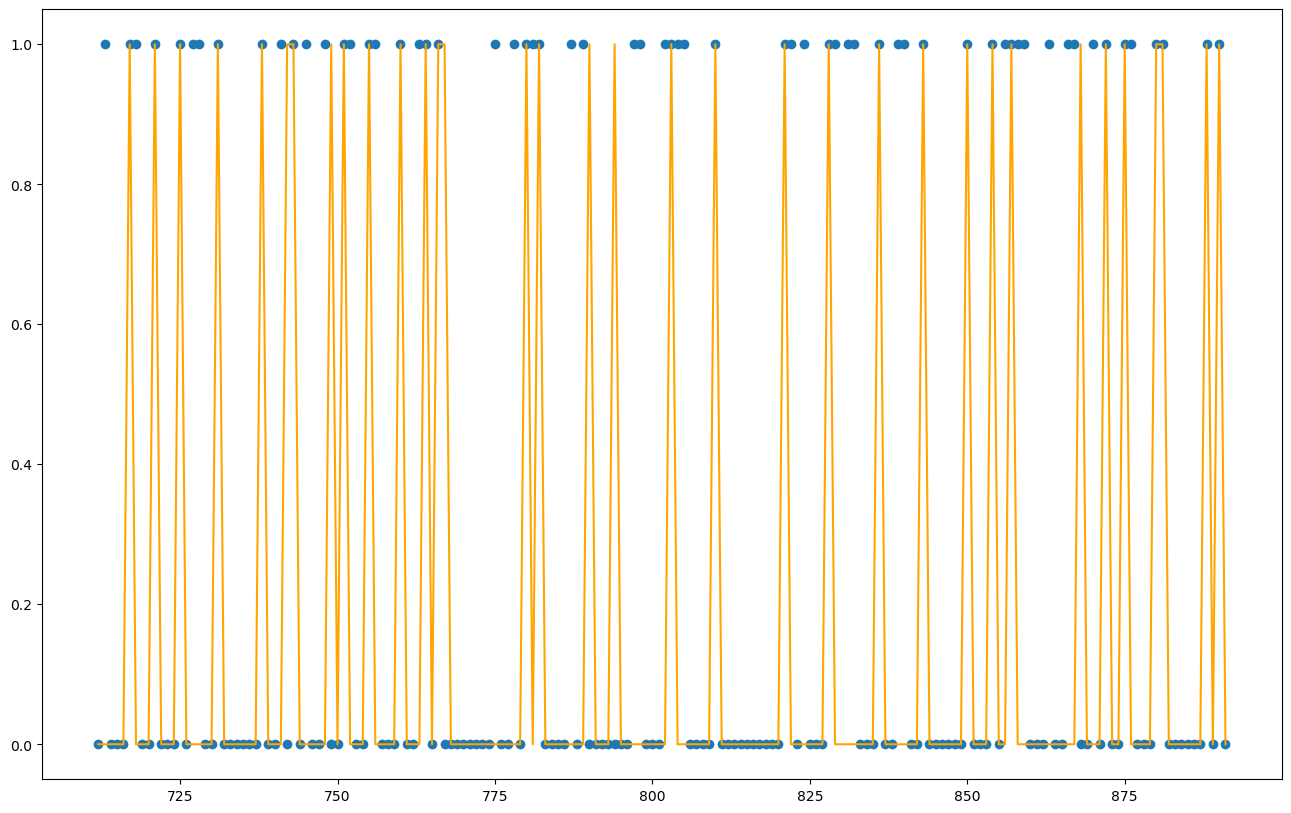

In [112]:
fig, ax = plt.subplots(figsize=(16, 10))
res = model.predict(X_test)
res = np.array([1 if res[i]>0.5 else 0 for i in range(res.size)])
ax.scatter(X_test.index, y_test)
ax.plot(X_test.index, res, color="orange")
plt.show()

# Benchmark submission

In [51]:
from sklearn.linear_model import LogisticRegression

In [89]:
m1 = LogisticRegression(max_iter=500)
m1.fit(X_train, y_train)
bench = m1.predict(test)
output = pd.DataFrame({"Survived" : bench}, index=test.index)
#output.to_csv("submission.csv")
print(output)

             Survived
PassengerId          
892                 0
893                 0
894                 0
895                 0
896                 1
...               ...
1305                0
1306                1
1307                0
1308                0
1309                0

[418 rows x 1 columns]


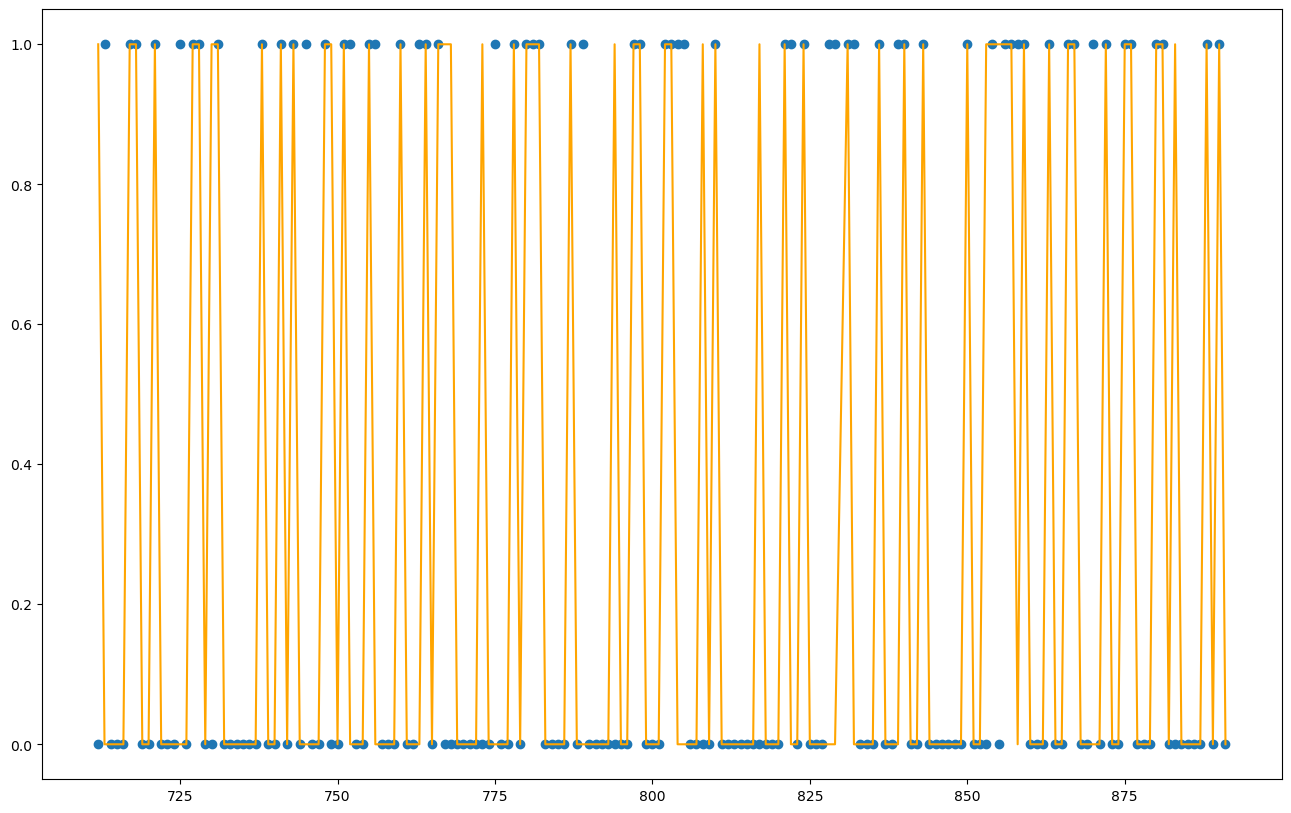

In [71]:
fig, ax = plt.subplots(figsize=(16, 10))
ax.scatter(X_test.index, y_test)
ax.plot(X_test.index, bench, color="orange")
plt.show()